In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [2]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

In [3]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))
    len_subsample = int(np.sqrt(len_sample))
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [6]:
np.random.seed(42)
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [7]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [8]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет прироста
def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле
def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    oob_forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [17]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_values, test_values, train_labels, test_labels, RD, train_accuracy, test_accuracy):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1, 2, 1)
    xx, yy = get_meshgrid(train_values)
    mesh_predictions = np.array(tree_vote(RD, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
    plt.scatter(train_values[:, 0], train_values[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
    plt.scatter(test_values[:, 0], test_values[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')


### Задание 1
Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [18]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = make_classification(n_samples=100,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=23)
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

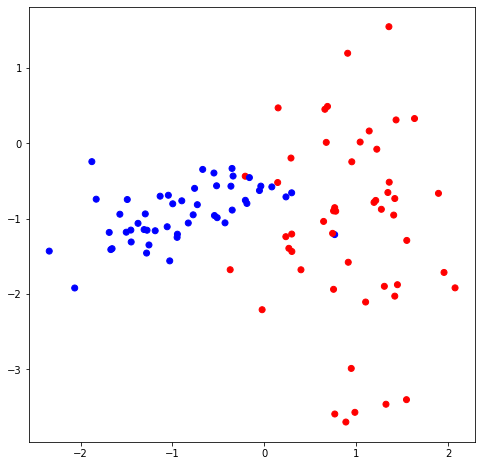

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [20]:
def grow_forest(train_data, train_labels, test_data, test_labels, n_trees):
    my_forest_1 = random_forest(train_data, train_labels, n_trees)
    
    # Точность на обучающей выборке
    train_answers = tree_vote(my_forest_1, train_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    
    # Точность на тестовой выборке
    test_answers = tree_vote(my_forest_1, test_data)
    test_accuracy = accuracy_metric(test_labels, test_answers)

    visualize(train_data, test_data, train_labels, test_labels, my_forest_1, train_accuracy, test_accuracy)


Wall time: 110 ms


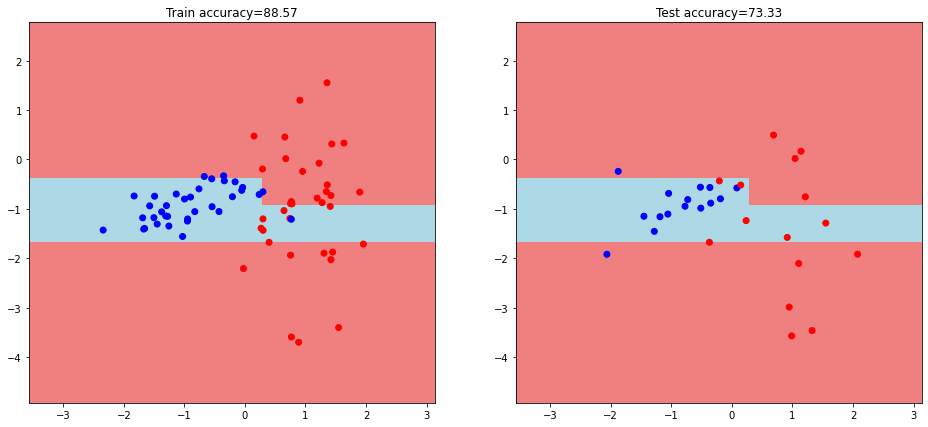

In [21]:
%%time
grow_forest(train_data, train_labels, test_data, test_labels, 1)

Wall time: 120 ms


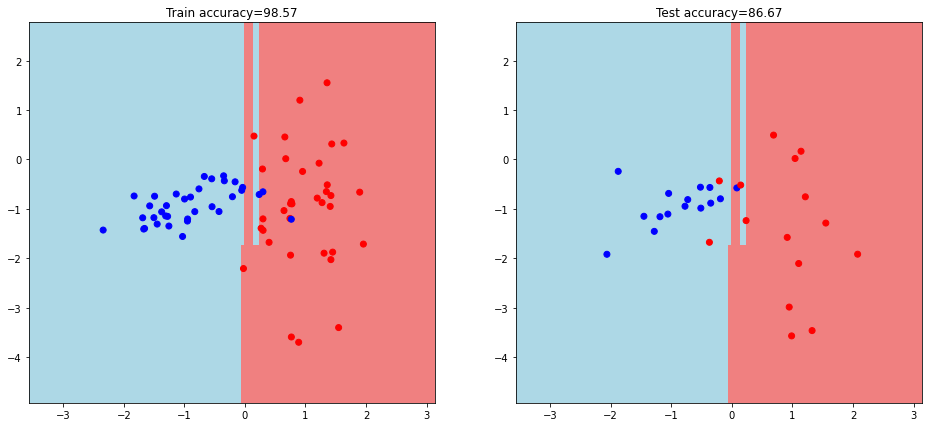

In [22]:
%%time
grow_forest(train_data, train_labels, test_data, test_labels, 3)

Wall time: 294 ms


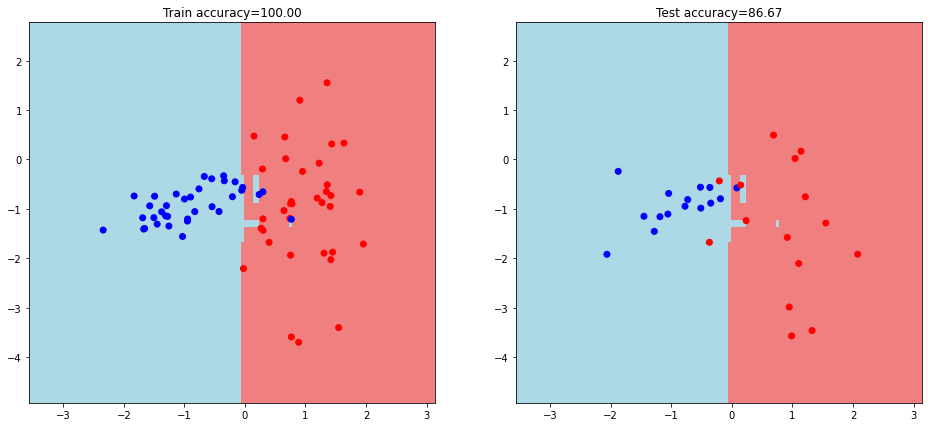

In [23]:
%%time
grow_forest(train_data, train_labels, test_data, test_labels, 10)

Wall time: 1.26 s


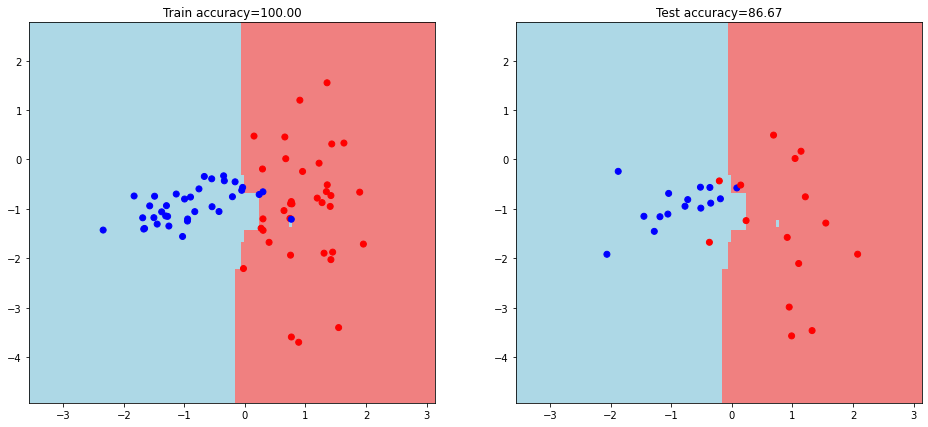

In [24]:
%%time
grow_forest(train_data, train_labels, test_data, test_labels, 50)

### Задание 2
Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.



Чем больше деревьев, тем лучше качество, но время настройки и работы RF также пропорционально увеличиваются.

### Задание 3
*Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [25]:
np.random.seed(42)
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        # добавляем индексы не вошедшие в "мешок"
        oob_idx = [i for i in np.arange(n_samples) if i not in sample_index]
        
        bootstrap.append((b_data, b_labels, oob_idx))
        
    return bootstrap

In [26]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    # для каждого дерева добавляем индексы, не вошеджие в "мешок"
    for b_data, b_labels, oob_idx in bootstrap:
        forest.append((build_tree(b_data, b_labels), oob_idx))
        
    return forest

In [27]:
def grow_forest(data, labels, n_trees):
    oob_idxs = set()
    forest = np.array(random_forest(data, labels, n_trees), dtype=list)
    my_forest_1 = forest[:, 0]

    # уникальные индексы не вошедшие в "мешок"
    for oob in forest[:, 1]:
        oob_idxs.update(set(oob)) 

    # ответы от деревьев по индексам на основании которых оно не строилось
    oob_answers = []
    for oob_obj in oob_idxs:
        # собираем лес из деревьев которые не строились на основании данного объекта
        oob_trees = [t for t, o in forest if oob_obj in o]
        
        # получаем данные по текущему индексу
        oobs = np.array([data[oob_obj]])
        # получаем ответ от леса
        oob_answers.append(tree_vote(oob_trees, oobs)[0])

    oob_idxs = list(oob_idxs)
    
    # расчитываем ошибку
    oobe = accuracy_metric(labels[oob_idxs], oob_answers)      
    return oobe

In [28]:
n_trees = [1, 3, 10, 50]
for tree_num in n_trees:
    print (f'Для леса из {tree_num} деревьев ошибка равна {grow_forest(classification_data, classification_labels, tree_num):.5}')

Для леса из 1 деревьев ошибка равна 87.179
Для леса из 3 деревьев ошибка равна 89.286
Для леса из 10 деревьев ошибка равна 89.0
Для леса из 50 деревьев ошибка равна 87.0


### Задание 4
*(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

In [29]:
# Расчет критерия энтропиb Шэннона
def shenon(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p) if p != 0 else 0
        
    return impurity

In [30]:
# Расчет прироста
def gain(left_labels, right_labels, root_shenon):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    # поменял критерий информативности
    return root_shenon - p * shenon(left_labels) - (1 - p) * shenon(right_labels)

In [31]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5
    # поменял критерий информативности
    root_shenon = shenon(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_shenon)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [32]:
n_trees = [1, 3, 10, 50]
for tree_num in n_trees:
    print (f'Для леса из {tree_num} деревьев ошибка равна {grow_forest(classification_data, classification_labels, tree_num):.5}')

Для леса из 1 деревьев ошибка равна 86.842
Для леса из 3 деревьев ошибка равна 85.938
Для леса из 10 деревьев ошибка равна 86.735
Для леса из 50 деревьев ошибка равна 89.0
